# Blog Post: The ADAM Algorithm for Optimization

In [81]:
%load_ext autoreload
%autoreload 2
from LogisticRegression import LogisticRegression, GradientDescentOptimizer, NewtonOptimizer, AdamOptimizer
import torch
from matplotlib import pyplot as plt 
import numpy as np
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
def classification_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    y = 1.0*y
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)
    
    return X, y

X, y = classification_data(noise = 0.5)

In [83]:
# plots data and boundary decision based on w
# only works for dimension = 2

def plot_data_and_boundary(X, y, w, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    # Plot the data
    targets = [0, 1]
    markers = ["o", ","]
    colors = ["red", "blue"]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = colors[i], cmap = "BrBG", marker = markers[i])

    # Draw the decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x_values = torch.linspace(x_min, x_max, 100)
    y_values = -(w[0]*x_values + w[2])/w[1]
    ax.plot(x_values, y_values, color='black')

    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")
    plt.show()

Let's take a quick look at this data before we get started with some experiments.

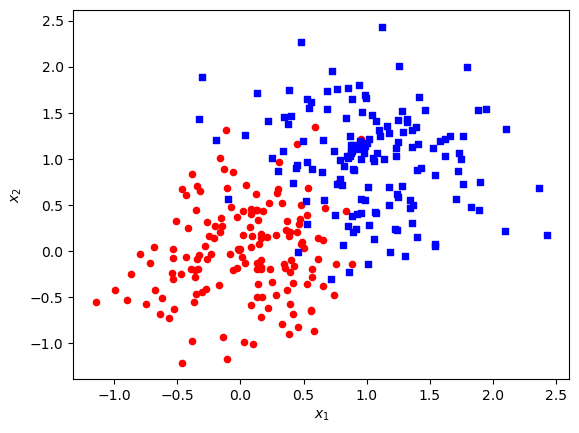

In [84]:
plot_data_and_boundary(X, y, [0, 0, 0])

# Experiment 1
To start with, let's check that this algorithm is actually working. In accordance with the parameters suggested by the paper as "good default settings" we'll set $\alpha = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$, and $\epsilon = 10^{-8}$.

torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torch.Size([300])
torch.Size([300, 3])
torc

Text(0, 0.5, 'Loss')

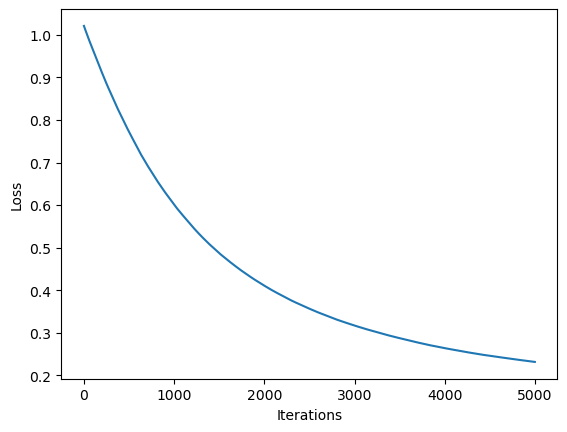

In [85]:
w = torch.linspace(-1, 1, X.shape[1])

adam = LogisticRegression(w) 
opt = AdamOptimizer(adam)

batch_size = 32
alpha = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 10e-8

losses = []

for _ in range(5000):
    losses.append(adam.loss(X, y))
    opt.step(X, y, batch_size, alpha, beta_1, beta_2, epsilon)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")

Ok so, with these parameters, Adam isn't the fastest. However, the losses are decreasing monotonically towards convergence, so we do like to see that. Perhaps increasing alpha could improve the rate of convergence.

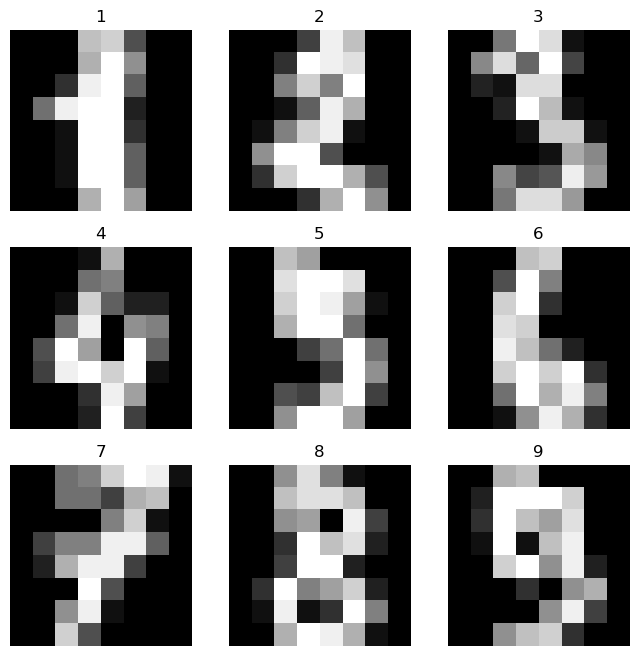

In [86]:
from sklearn.datasets import load_digits
import pandas as pd 

digits = load_digits()

df = pd.DataFrame(data = digits.data)
df['target'] = digits.target

fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize = (8, 8))

for digit in range(1, 10):
    digit_data = df[df["target"] == digit].head(1)
    digit_image = digit_data.iloc[0, :-1].values.reshape(8, 8)
    ax = axes[(digit - 1) // 3, (digit - 1) % 3]
    ax.imshow(digit_image, cmap = "gray")
    ax.set_title(f"{digit}")
    ax.axis("off")

plt.show()


Since our logistic regression is only set up to do binary classification, lets choose just two digits. I'm going to go with 2 and 7, as the sample images above look pretty similar, and I want to see if the model can successfully overcome this challenge.

In [87]:
two_n_seven = df[df["target"].isin([1, 3])].copy()
two_n_seven.loc[:, "label"] = (two_n_seven["target"] == 1).astype(int)

In [88]:
X_27 = torch.tensor(two_n_seven.drop(columns = ["label", "target"]).values, dtype = float).float()
y_27 = torch.tensor(two_n_seven["label"].values, dtype = float).float()

Now that our data is in familiar X and y form, we can run AdamOptimizer and see how it goes.

Text(0, 0.5, 'Loss')

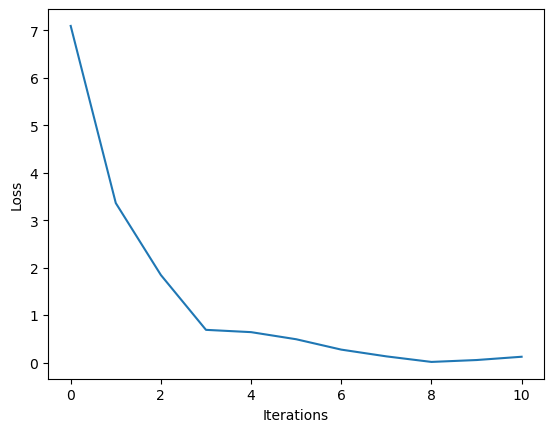

In [95]:
w = torch.linspace(-1, 1, X_27.shape[1])

adam = LogisticRegression(w) 
opt = AdamOptimizer(adam)

epsilon = 10e-6
alpha = 0.1

losses = []

for _ in range(1000):
    losses.append(adam.loss(X_27, y_27))
    opt.step(X_27, y_27, batch_size, alpha, beta_1, beta_2, epsilon)

plt.plot(losses)
plt.xlabel("Iterations")
plt.ylabel("Loss")